# Using Xarray-Spatial and Datashader to Quantify Pharmacy Deserts

In [1]:
import datashader as ds
import numpy as np
import pandas as pd
import datashader as ds
import geopandas as gpd

from datashader.transfer_functions import stack
from datashader.transfer_functions import shade
from datashader.transfer_functions import set_background
from datashader.colors import inferno

from xrspatial.classify import natural_breaks
from xrspatial.classify import binary
from xrspatial import proximity

from spatialpandas import GeoDataFrame

## Load data

In [2]:
# Load Pharmacies and add out x, y fields based on CalcLocation
pharmacy_df = pd.read_csv("pharmacy_locations.csv")
coords = pharmacy_df['CalcLocation'].str.split(',', expand=True)
pharmacy_df['y'] = np.array(coords[0], dtype='float64')
pharmacy_df['x'] = np.array(coords[1], dtype='float64')

In [3]:
# Load Census Block Groups and Calculate Percent over 65 years-old
blockgroup_df = GeoDataFrame(gpd.read_file("bg_wgs84.shp"))
blockgroup_df['ABOVE_65'] = blockgroup_df[['AGE_65_74', 'AGE_75_84', 'AGE_85_UP']].sum(axis=1) 
blockgroup_df['PCT_ABOVE_65'] = blockgroup_df['ABOVE_65'] / blockgroup_df['POPULATION']

In [48]:
# Load Census County and Calculate Percent over 65 years-old
county_df = GeoDataFrame(gpd.read_file("counties_wgs84.shp"))
county_df['ZONE_ID'] = county_df['OBJECTID'].astype(np.int16)

## Define Study Area

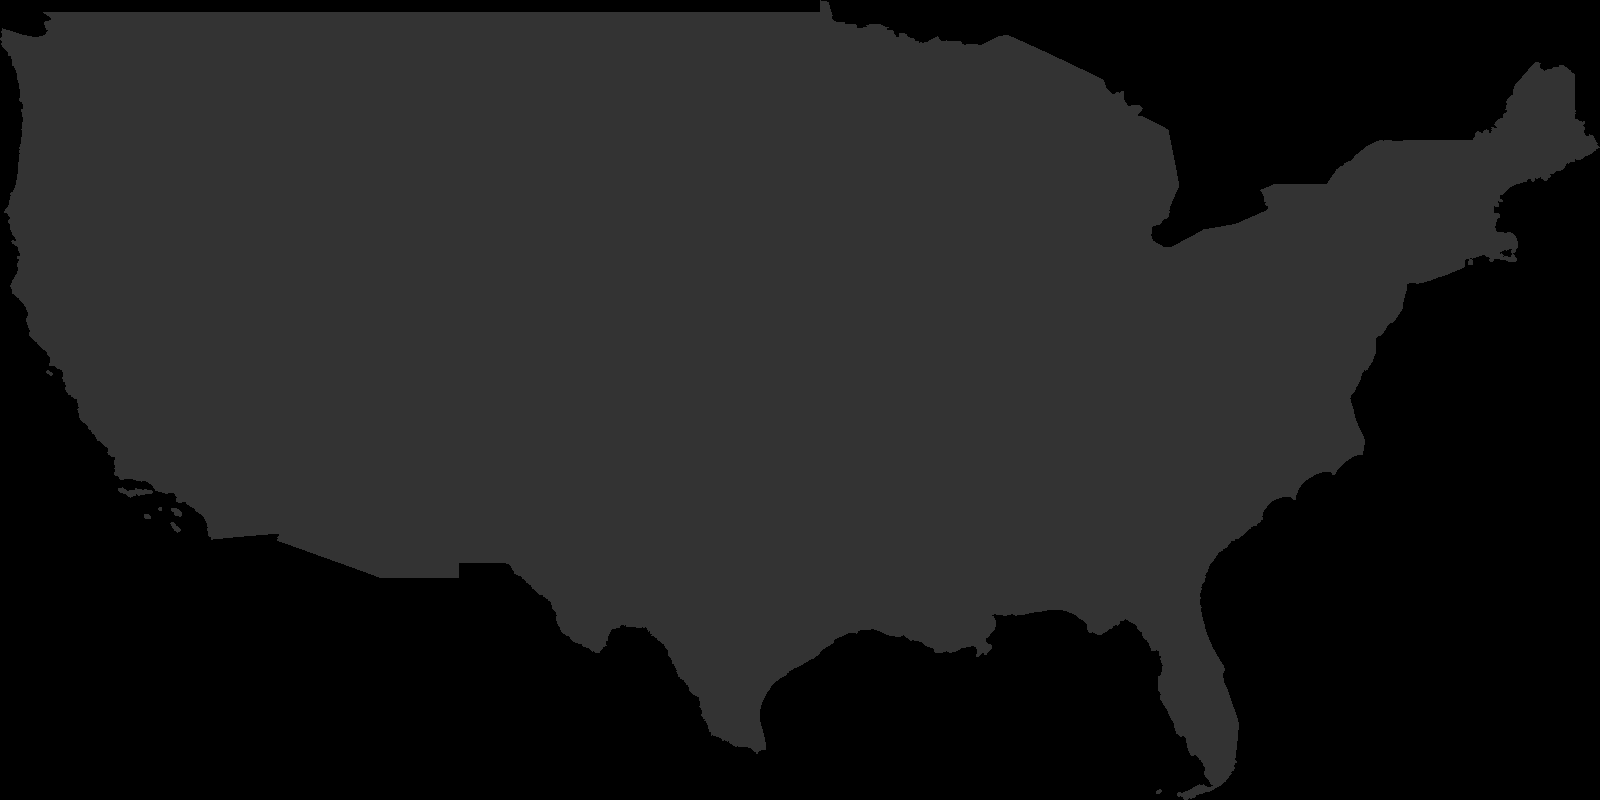

In [68]:
x_range = (-124.848974, -66.885444)
y_range = (24.396308, 49.384358)

W = 1600
H = 800

cvs = ds.Canvas(plot_width=W, plot_height=H,
                x_range=x_range, y_range=y_range)

county_mask = cvs.polygons(county_df, geometry='geometry')
set_background(shade(county_mask, cmap='#333333', alpha=255), 'black')

### Create a "Distance to Nearest Pharmacy" Layer & Classify into 5 Groups

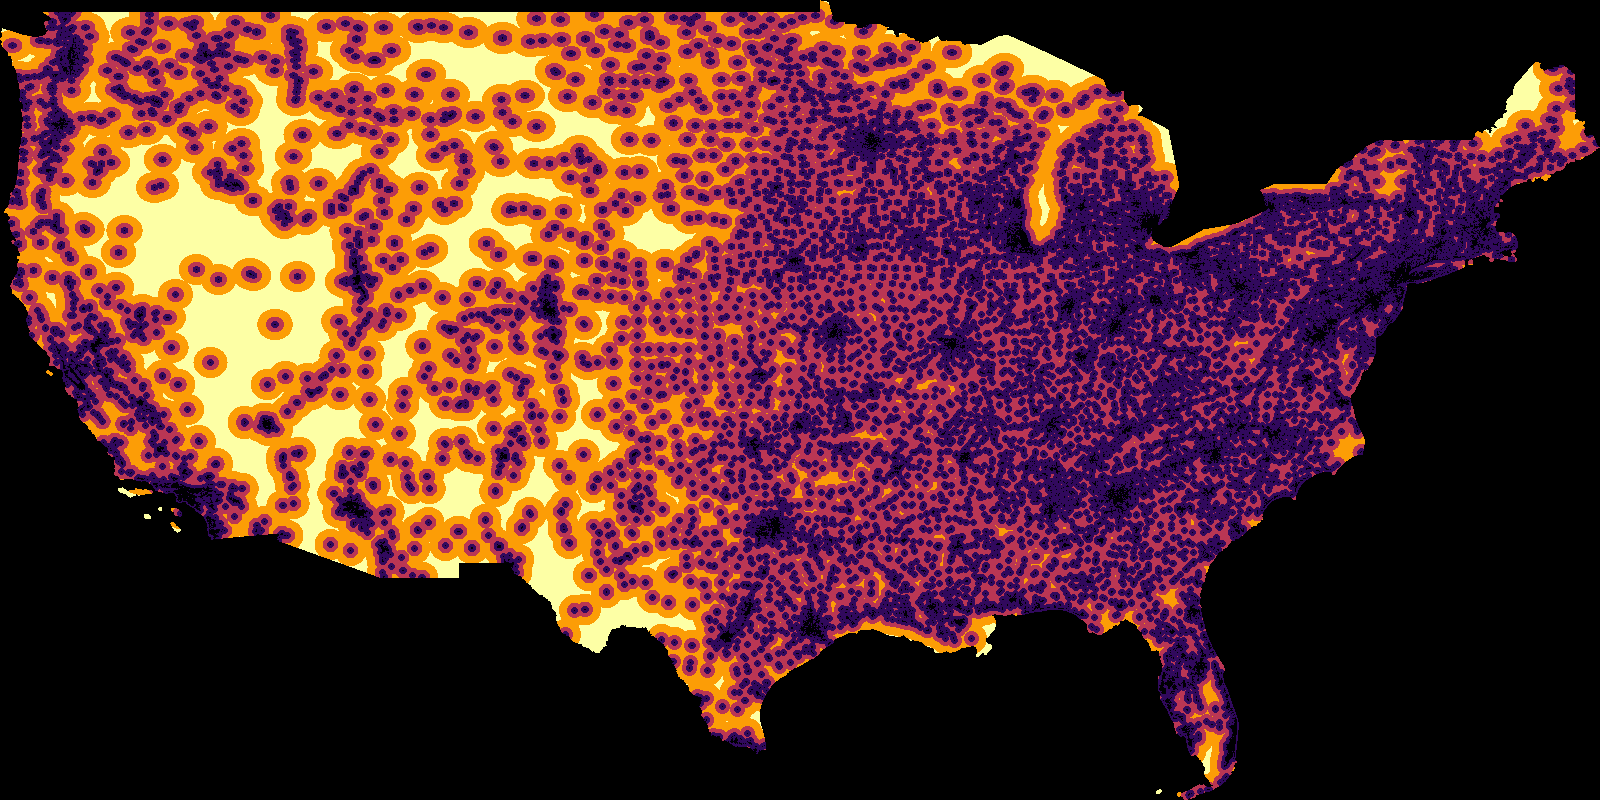

In [69]:
pharmacy_raster = cvs.points(pharmacy_df, 'x', 'y')
proximity_raster = proximity(pharmacy_raster, distance_metric='GREAT_CIRCLE').where(county_mask)
proximity_raster.data[~np.isfinite(proximity_raster.data)] = 0.0

proximity_classifed = natural_breaks(proximity_raster, k=5).where(county_mask)

image_pharmacy = shade(proximity_classifed, cmap=inferno, alpha=255)
image_pharmacy = set_background(image_pharmacy, 'black')
image_pharmacy

### Create an Age Layer  & Classify into 5 Groups

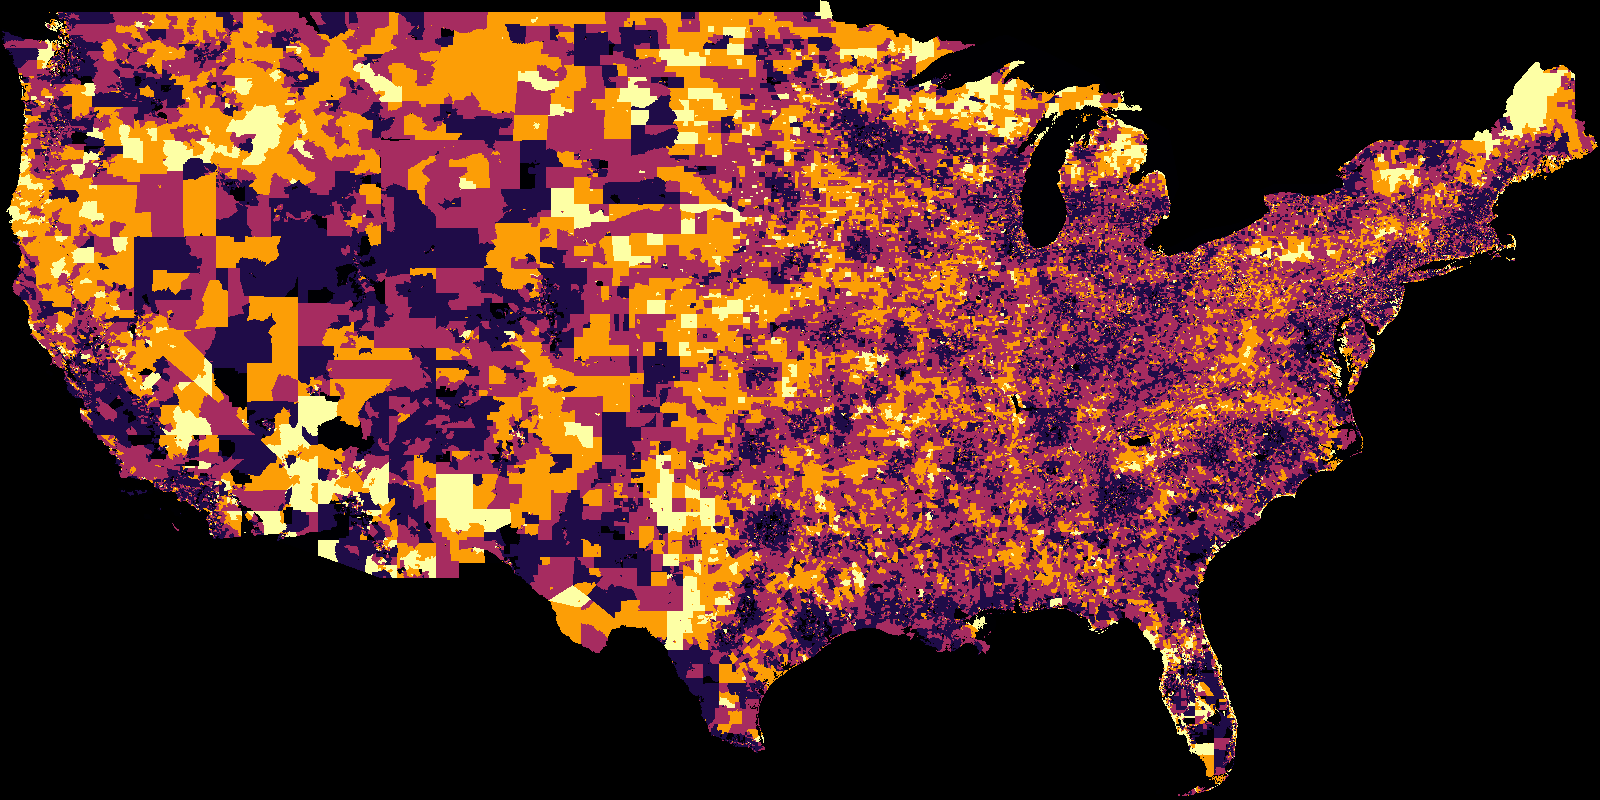

In [70]:
age_raster = cvs.polygons(blockgroup_df, geometry='geometry', agg=ds.mean('PCT_ABOVE_65'))
age_raster.data[~np.isfinite(age_raster.data)] = 0.0
age_classifed = natural_breaks(age_raster, k=5).where(county_mask)

age_image = shade(age_classifed, cmap=inferno, alpha=255)
age_image = set_background(age_image, 'black')
age_image

### Combine layers to highlight seniors at risk from pharmacy deserts

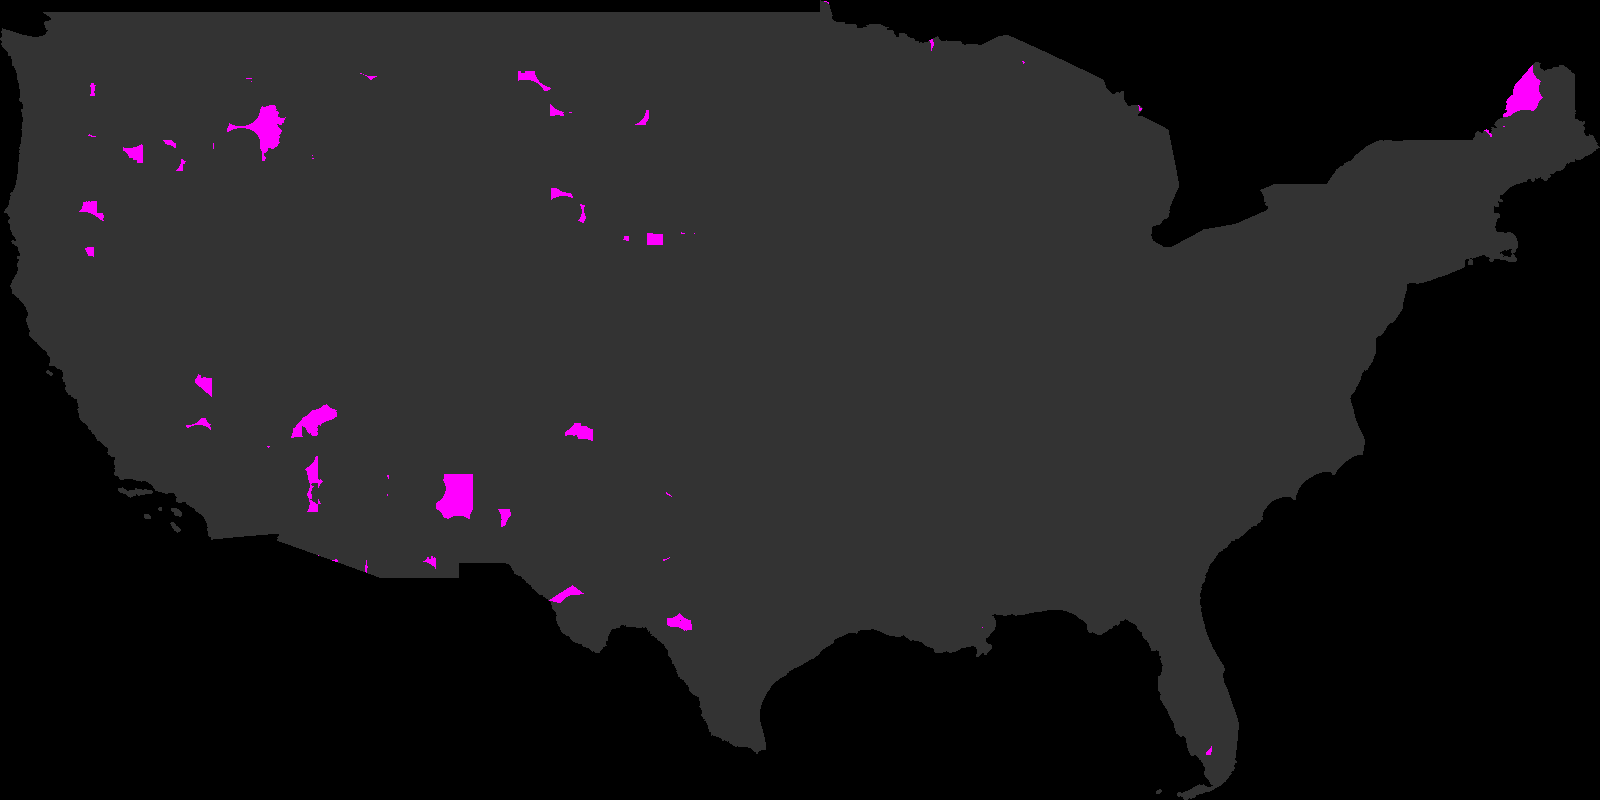

In [71]:
pharmacy_deserts = binary(proximity_classifed, [4.0])
older_regions = binary(age_classifed, [4.0])
target_deserts = (pharmacy_deserts * older_regions).where(county_mask)
target_deserts_img = shade(target_deserts, cmap=['#333333', 'fuchsia'], alpha=255, how='linear')
set_background(target_deserts_img, 'black')

###  Summarize seniors at risk by county

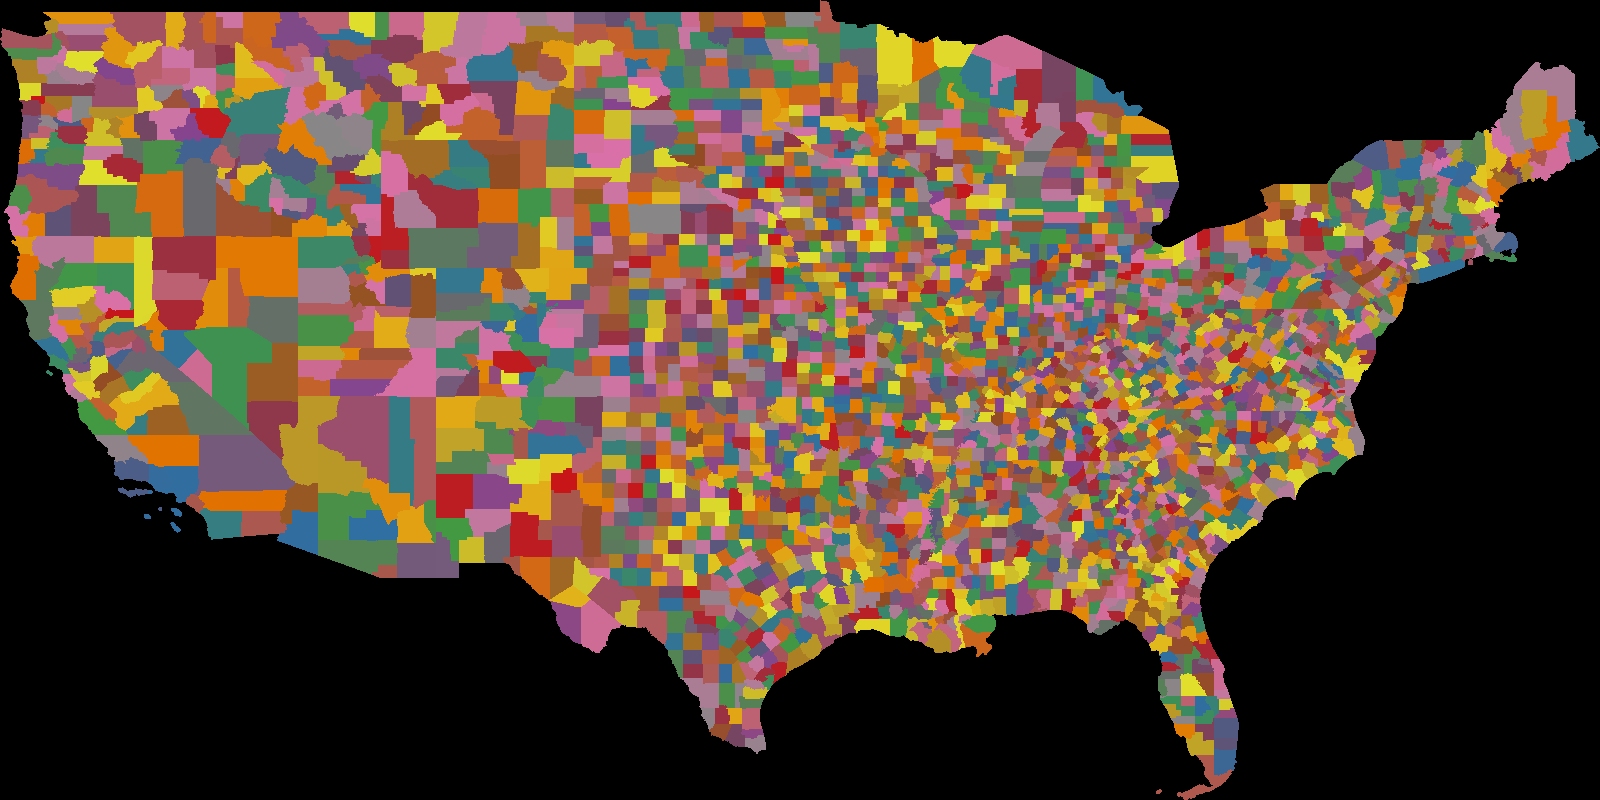

In [72]:
from datashader.colors import Set1

counties_raster = cvs.polygons(county_df, geometry='geometry', agg=ds.max('OBJECTID'))
counties_image = shade(counties_raster, cmap=Set1, alpha=225, how='linear')
set_background(counties_image, 'black')

## Zonal Statistics

Zonal statistics allows for calculating summary statistics for specific areas or zones within a datashader aggregate. Zones are defined by creating an integer aggregate where the cell values are zone_ids. The output of zonal statistics is a Pandas dataframe containing summary statistics for each zone based on a value raster.


In [84]:
from xrspatial import zonal_stats

# summary functions
zonal_funcs = dict(pharmacy_desert_mean=lambda z: z.mean())

# zones
counties_raster.data = counties_raster.data.astype(np.int64)

# values to summarize
target_deserts.data = target_deserts.data.astype(np.int8)

# execute summary functions on each zone and take top 10
results = zonal_stats(counties_raster, target_deserts, zonal_funcs)

### Join result back to counties layer

In [94]:

cols = ['pharmacy_desert_mean', 'NAME', 'STATEFP', 'geometry']
final_df = pd.merge(county_df, results, left_on='ZONE_ID', right_index=True)[cols]
final_df.nlargest(10, 'pharmacy_desert_mean')

,pharmacy_desert_mean,NAME,STATEFP,geometry
2632,1.000000,Hooker,31,"MultiPolygon([[[-101.42650100042079, 42.031478..."
31,0.811054,Catron,35,"MultiPolygon([[[-109.0468839997967, 33.9567449..."
1076,0.640333,Harding,35,"MultiPolygon([[[-103.93097700038822, 35.732781..."
988,0.515766,Wheeler,41,"MultiPolygon([[[-120.38568700035474, 44.761174..."
3135,0.471861,Prairie,30,"MultiPolygon([[[-105.51092299959674, 46.658094..."
1845,0.470226,Jeff Davis,48,"MultiPolygon([[[-104.10155400021688, 30.452606..."
890,0.444685,Edwards,48,"MultiPolygon([[[-100.64540100035583, 30.288170..."
1082,0.418301,Real,48,"MultiPolygon([[[-100.06364900040103, 29.711088..."
573,0.340596,Idaho,16,"MultiPolygon([[[-116.47756799976332, 46.122927..."
1114,0.334356,Valley,16,"MultiPolygon([[[-116.18843399962937, 44.750379..."


In [113]:
from xrspatial import hillshade

counties_raster = cvs.polygons(county_df, geometry='geometry', agg=ds.max('OBJECTID'))

desert_raster = cvs.polygons(final_df.nlargest(10, 'pharmacy_desert_mean'),
                             geometry='geometry',
                             agg=ds.mean('pharmacy_desert_mean'))

county_mask = cvs.polygons(county_df, geometry='geometry')

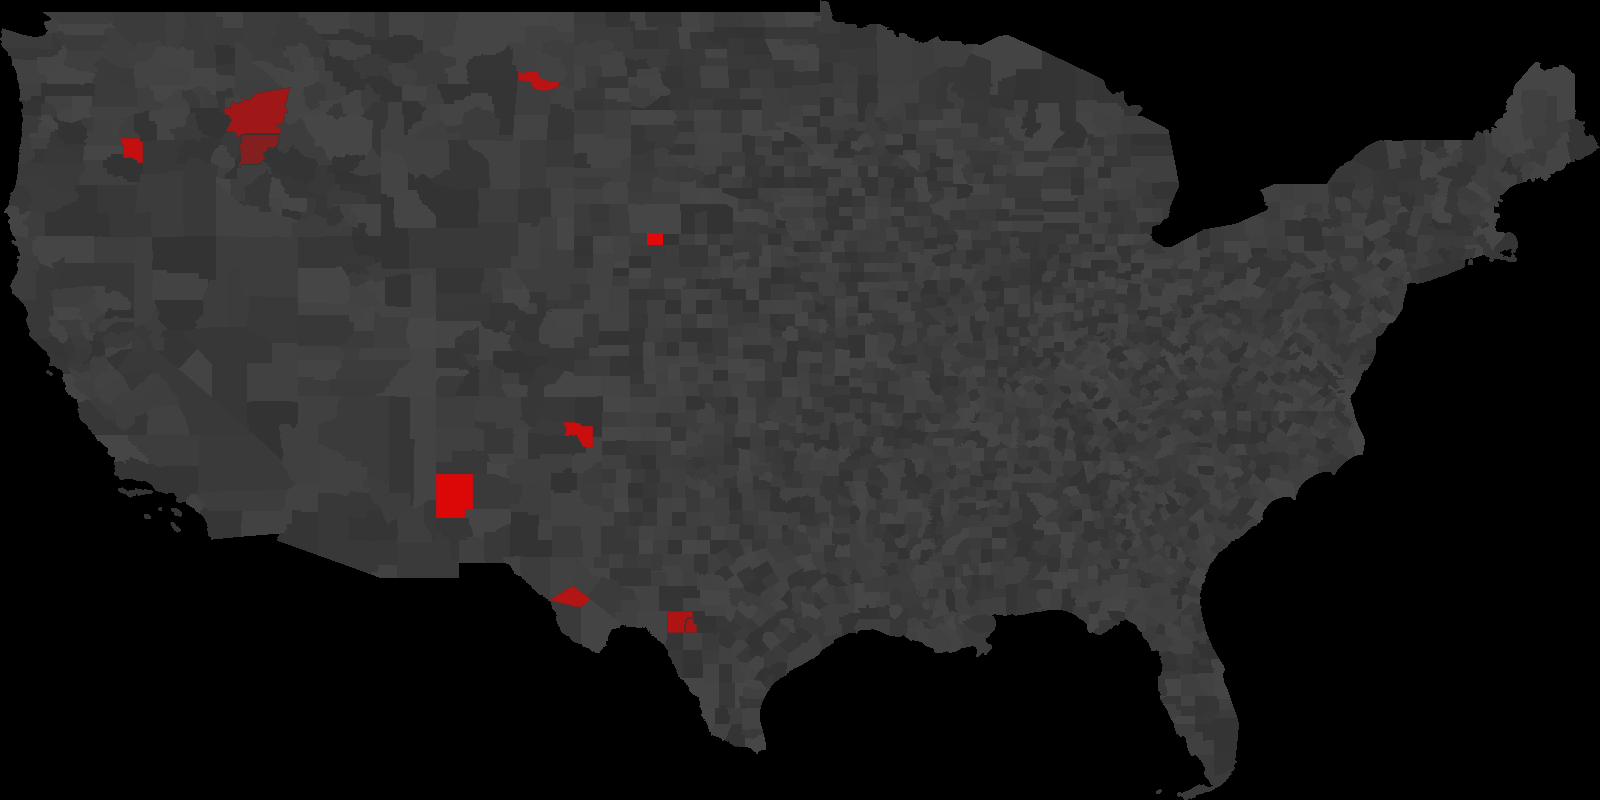

In [133]:
img = stack(
    shade(county_mask, cmap=['#333333'], alpha=255),
    shade(counties_raster, cmap=['#333333', '#ffffff'], alpha=25),
    shade(desert_raster, cmap=['#333333','#ff0000'], alpha=200),
    shade(hillshade(desert_raster), cmap=['#333333', '#ff0000'], alpha=100),
)
set_background(img, 'black')